<a href="https://colab.research.google.com/github/LokeRuiKee/timeseries-forecasting-HuggingFace/blob/main/time_series_forecastv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install huggingface_hub
!pip install transformers
!pip install -q gluonts ujson
!pip install -q accelerate
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 4.5 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load your dataset
file_path = "/content/dataset.csv"
df = pd.read_csv(file_path)

# Convert "Timestamp" column to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Drop rows with NaN values in both "Timestamp" and "1233" columns
df.dropna(subset=["Timestamp", "1233"], inplace=True)

# Assuming x and y are defined as follows
x = df["Timestamp"]
y = df["1233"]

freq = "15T"  # Frequency of 15 minutes

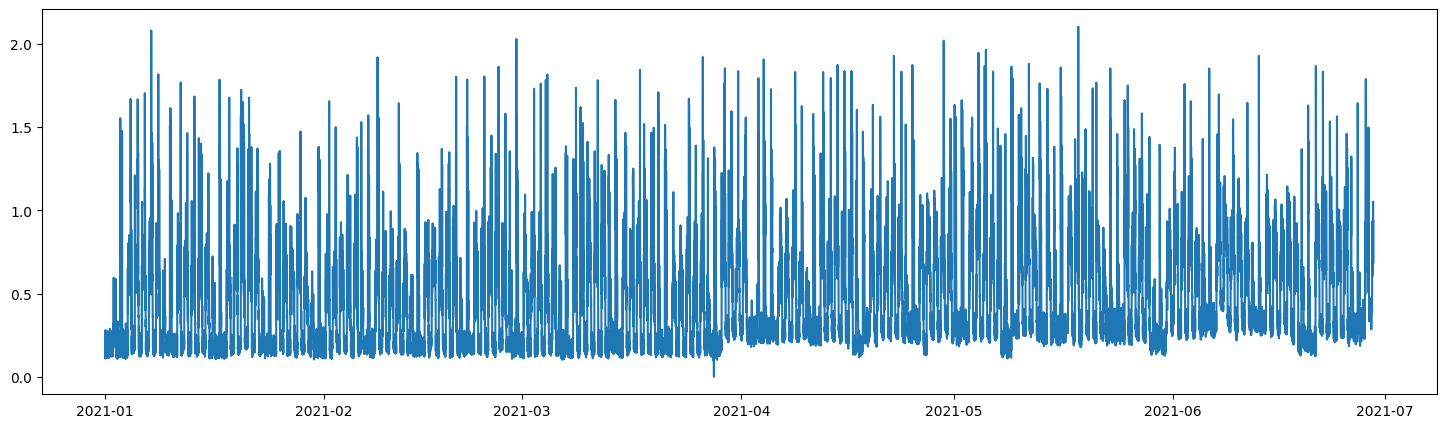

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (18,5)
plt.plot(x,y)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from gluonts.dataset.common import ListDataset

# Combine x and y into a DataFrame
data = pd.concat([x, y], axis=1)

# Split the data into training and testing sets
# Here, I'm assuming an 80-20 split, you can adjust the test_size parameter as needed
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Separate the features and target for training and testing sets
train_x = train_data["Timestamp"]
train_y = train_data["1233"]

test_x = test_data["Timestamp"]
test_y = test_data["1233"]

In [6]:
import pandas as pd
from gluonts.dataset.common import ListDataset

# Convert "Timestamp" column to datetime and set as index
train_data["Timestamp"] = pd.to_datetime(train_data["Timestamp"])
train_data = train_data.set_index("Timestamp")

# Extract target values
target_values = train_data["1233"]

# Prepare dataset
data = [{"start": train_data.index[0], "target": target_values.values}]
train_dataset = ListDataset(data, freq="15T")

print(train_dataset)

[{'start': Period('2021-01-01 00:15', '15T'), 'target': array([0.149, 0.197, 0.28 , ..., 0.226, 0.255, 0.306], dtype=float32)}]


# Update start to pd.Period

In [7]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [8]:
from functools import partial
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

def transform_dataset(dataset, freq):
    start_date = dataset["start"]
    target_values = dataset["target"]

    dataset[FieldName.START] = start_date
    dataset[FieldName.TARGET] = target_values

    return dataset

# Convert pandas DataFrame to GluonTS ListDataset
train_dataset = ListDataset(
    [{"target": train_y.values, "start": train_x.iloc[0]}],
    freq=freq,
)

test_dataset = ListDataset(
    [{"target": test_y.values, "start": test_x.iloc[0]}],
    freq=freq,
)

# Apply transformation to train and test datasets
train_dataset = list(map(partial(transform_dataset, freq=freq), train_dataset))
test_dataset = list(map(partial(transform_dataset, freq=freq), test_dataset))


In [9]:
train_dataset

[{'target': array([0.149, 0.197, 0.28 , ..., 0.226, 0.255, 0.306], dtype=float32),
  'start': Period('2021-01-01 00:15', '15T')}]

# Define the Model

In [10]:
from gluonts.time_feature import get_lags_for_frequency

freq = "15T"  # Frequency of 15 minutes
prediction_length = 96  # Predicting 96 steps ahead, for predicting 1 day into the future

# For predicting the next 15 minutes
prediction_length_15min = 1

# For predicting the next hour
prediction_length_1hr = 4

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 95, 96, 97, 191, 192, 193, 287, 288, 289, 383, 384, 385, 479, 480, 481, 575, 576, 577, 671, 672, 673]


In [11]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function minute_of_hour at 0x7e0ee7bac670>, <function hour_of_day at 0x7e0ee7bac3a0>, <function day_of_week at 0x7e0ee7bac700>, <function day_of_month at 0x7e0ee7bac790>, <function day_of_year at 0x7e0ee7bac820>]


In [12]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=0,
    # it has 366 possible values:
    cardinality=[len(train_data)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [13]:
import pandas as pd

# Convert start timestamps to pandas Timestamp objects
train_dataset_pd = pd.DataFrame(train_dataset)
train_dataset_pd['start'] = pd.to_datetime(train_dataset_pd['start'].astype(str))

# Extract additional time features
train_dataset_pd['day_of_week'] = train_dataset_pd['start'].dt.dayofweek
train_dataset_pd['month_of_year'] = train_dataset_pd['start'].dt.month
train_dataset_pd['hour_of_day'] = train_dataset_pd['start'].dt.hour

# Convert back to list of dictionaries
train_dataset_with_time_features = train_dataset_pd.to_dict('records')

In [14]:
train_dataset_pd

,target,start,day_of_week,month_of_year,hour_of_day
0,"[0.149, 0.197, 0.28, 0.112, 0.246, 0.111, 0.2,...",2021-01-01 00:15:00,4,1,0


In [15]:
import pandas as pd

# Update the configuration to reflect the new time features
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length * 2,
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 3,  # Including additional time features
    num_static_categorical_features=0,  # No static categorical features
    cardinality=None,  # No need to specify cardinality if there are no static categorical features
    embedding_dimension=None,  # No need to specify embedding dimension if there are no static categorical features
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

In [16]:
model.config.distribution_output

'student_t'

# Define Transformations

In [17]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [18]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

# Define InstanceSplitter

In [19]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

# Create Dataloaders

In [20]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [21]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # We create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [22]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [23]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [24]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 865, 6]) torch.FloatTensor
past_values torch.Size([256, 865]) torch.FloatTensor
past_observed_mask torch.Size([256, 865]) torch.FloatTensor
future_time_features torch.Size([256, 96, 6]) torch.FloatTensor
future_values torch.Size([256, 96]) torch.FloatTensor
future_observed_mask torch.Size([256, 96]) torch.FloatTensor


# single forward pass with the batch we just created

In [25]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

print("Loss:", outputs.loss.item())

Loss: 0.8351191878318787


# Train the model

In [26]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

0.8432877659797668
-0.2942899763584137
-0.5164422988891602
-0.753213107585907
-0.7639771103858948
-0.8582143187522888
-0.8726143836975098
-0.916523277759552
-0.9345293045043945
-0.9458940029144287


# Inference

In [27]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [28]:
forecasts[0].shape

(1, 100, 96)

In [29]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(1, 100, 96)


# Evaluate the resulting forecast

In [30]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])


# plot the individual metrics

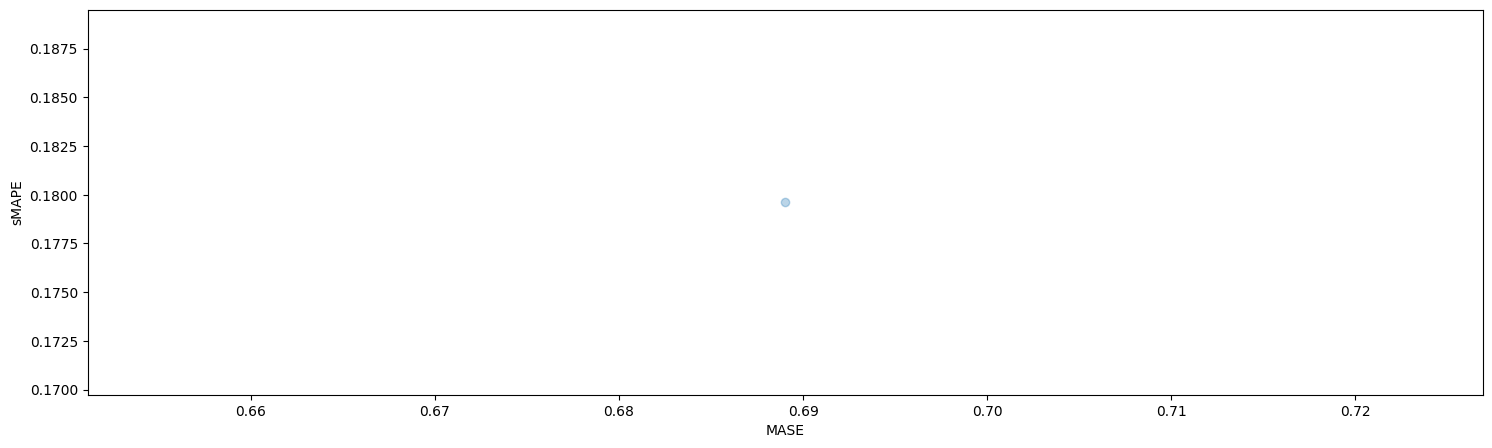

In [31]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

# Plot rediction for any time series (ignore this section)

In [32]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:],
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

In [38]:
print(len(test_dataset))

1


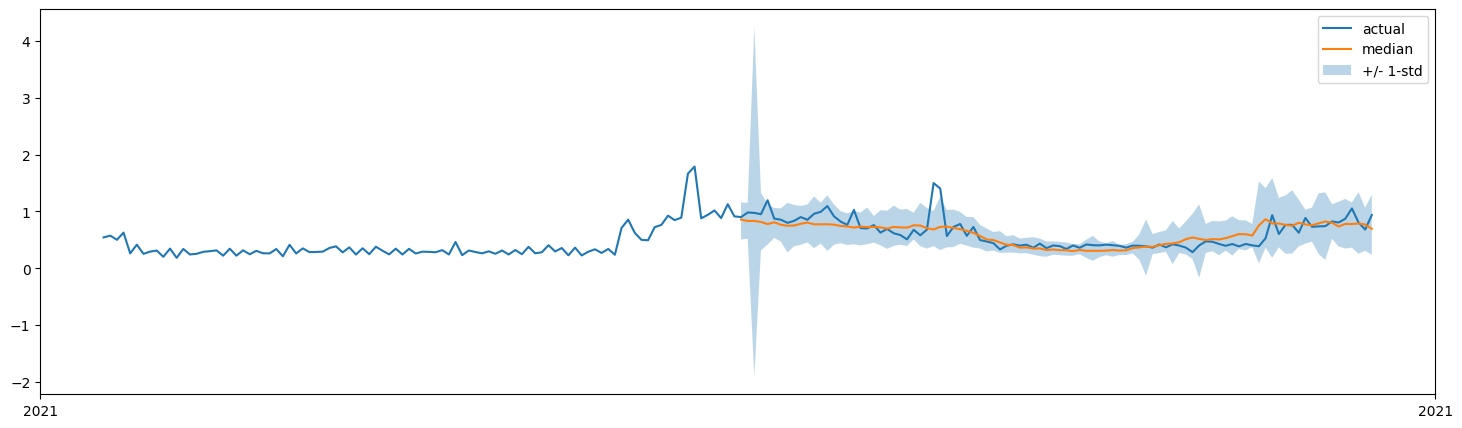

In [39]:
plot(0)

# creating forecast task, display forecast with graph

In [67]:
# Modify the test data loader to generate batches for the next 1 day
def create_next_day_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    # Only include past features and values, and future features for the next day
    field_names = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",  # Include only future time features for the next day
    ]
    if config.num_static_categorical_features > 0:
        field_names.append("static_categorical_features")

    if config.num_static_real_features > 0:
        field_names.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    instance_sampler = create_instance_splitter(config, "test")
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=field_names,
    )

# Create the next day data loader
next_day_dataloader = create_next_day_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=1,  # Batch size 1 to get forecasts for one day at a time
)

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

# Concatenate forecasts from all batches into a single array
forecasts = np.concatenate(forecasts, axis=1)

# Now you have only one forecast for the entire dataset

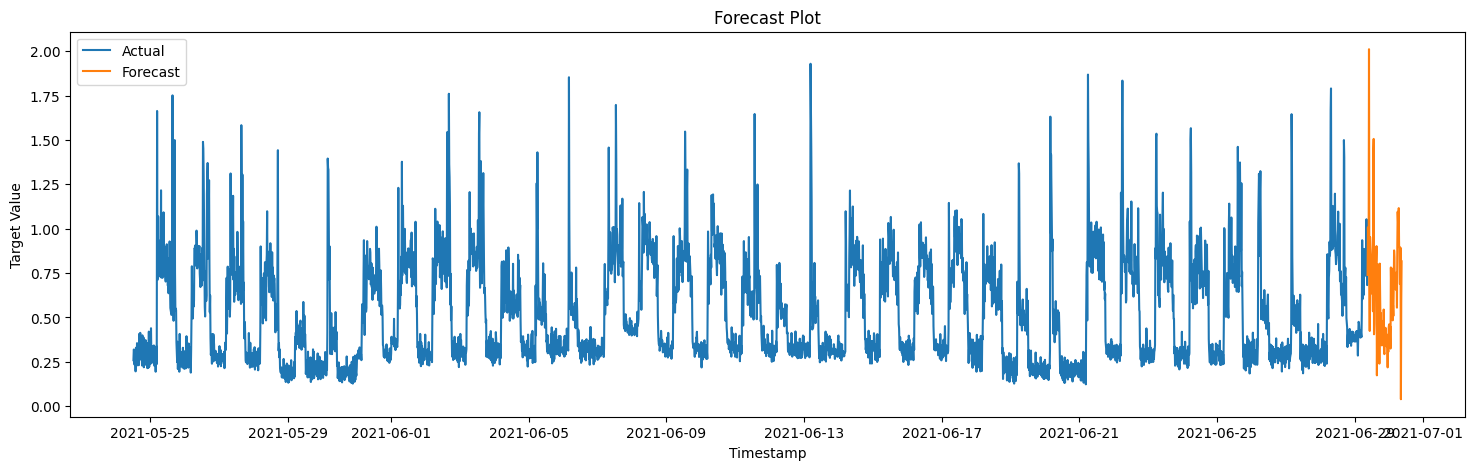

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecasts(test_dataset, forecasts):
    # Extract the timestamp and target values from the test dataset
    timestamps = pd.date_range(start=test_dataset[0]['start'].to_timestamp(), periods=len(test_dataset[0]['target']), freq='15min')
    target_values = test_dataset[0]['target']

    # Plot the actual target values
    plt.plot(timestamps, target_values, label='Actual')

    # Plot the forecasted values
    forecast_timestamps = pd.date_range(start=timestamps[-1], periods=len(forecasts[0][0]), freq='15min')
    forecast_values = forecasts[0][0]  # Assuming you have only one forecast
    plt.plot(forecast_timestamps, forecast_values, label='Forecast')

    plt.xlabel('Timestamp')
    plt.ylabel('Target Value')
    plt.title('Forecast Plot')
    plt.legend()
    plt.show()

# Plot the forecasts
plot_forecasts(test_dataset, forecasts)

In [74]:
forecasts

array([[[ 0.73930717,  1.0067147 ,  0.91229206, ...,  0.03902443,
          0.58859396,  0.8161483 ],
        [ 0.8502465 ,  0.85475916,  0.84843516, ...,  0.74850196,
          0.67063016,  0.48938096],
        [ 0.9303815 ,  0.70671713,  0.7978985 , ...,  0.75434035,
          0.8561096 ,  0.6486149 ],
        ...,
        [ 0.5528594 ,  2.5498803 , -0.30600995, ...,  1.0189142 ,
          0.26961583,  0.72855383],
        [ 0.66516006,  0.74210477,  0.49770913, ...,  0.73635983,
          0.8053401 ,  1.380392  ],
        [ 0.7507792 ,  1.0372474 ,  0.60708857, ...,  0.76384276,
          0.7502139 ,  2.95084   ]]], dtype=float32)

In [73]:
test_dataset

[{'target': array([0.259, 0.319, 0.312, ..., 0.806, 0.682, 0.938], dtype=float32),
  'start': Period('2021-05-24 12:15', '15T')}]

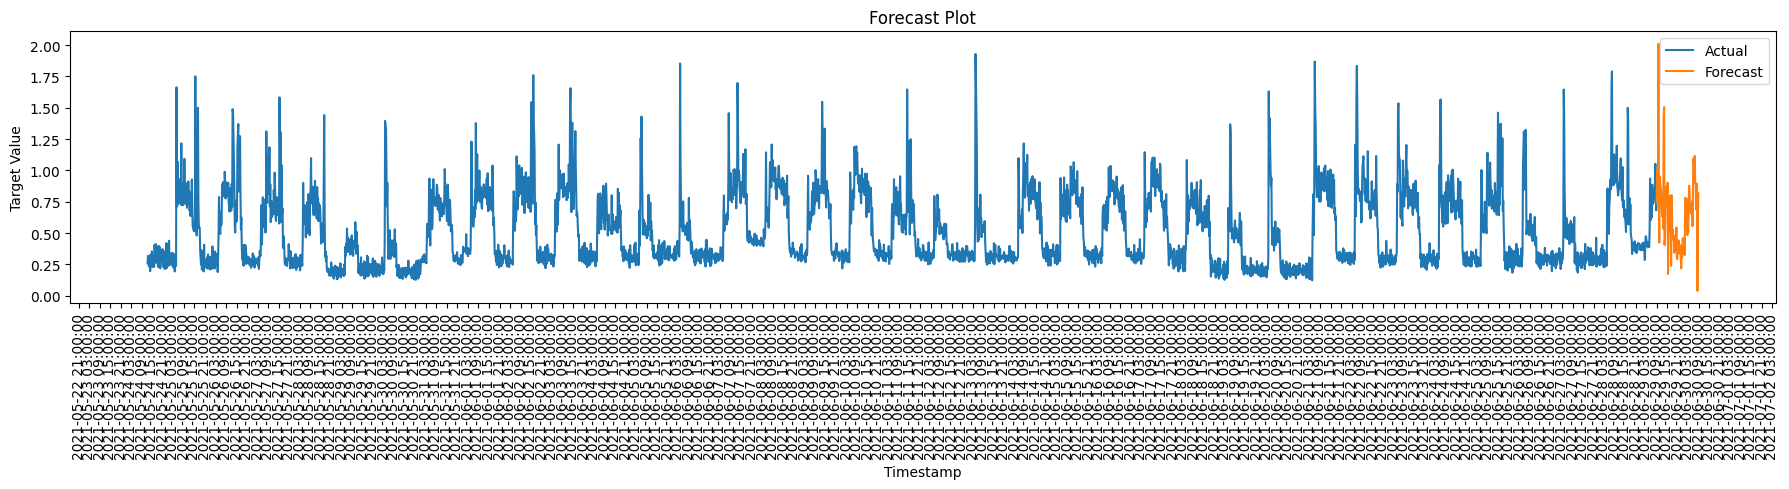

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecasts(test_dataset, forecasts):
    # Extract the timestamp and target values from the test dataset
    timestamps = pd.date_range(start=test_dataset[0]['start'].to_timestamp(), periods=len(test_dataset[0]['target']), freq='15min')
    target_values = test_dataset[0]['target']

    # Plot the actual target values
    plt.plot(timestamps, target_values, label='Actual')

    # Plot the forecasted values
    forecast_timestamps = pd.date_range(start=timestamps[-1], periods=len(forecasts[0][0]), freq='15min')
    forecast_values = forecasts[0][0]  # Assuming you have only one forecast
    plt.plot(forecast_timestamps, forecast_values, label='Forecast')

    # Format the x-axis ticks for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Set interval as needed

    plt.xlabel('Timestamp')
    plt.ylabel('Target Value')
    plt.title('Forecast Plot')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Plot the forecasts
plot_forecasts(test_dataset, forecasts)

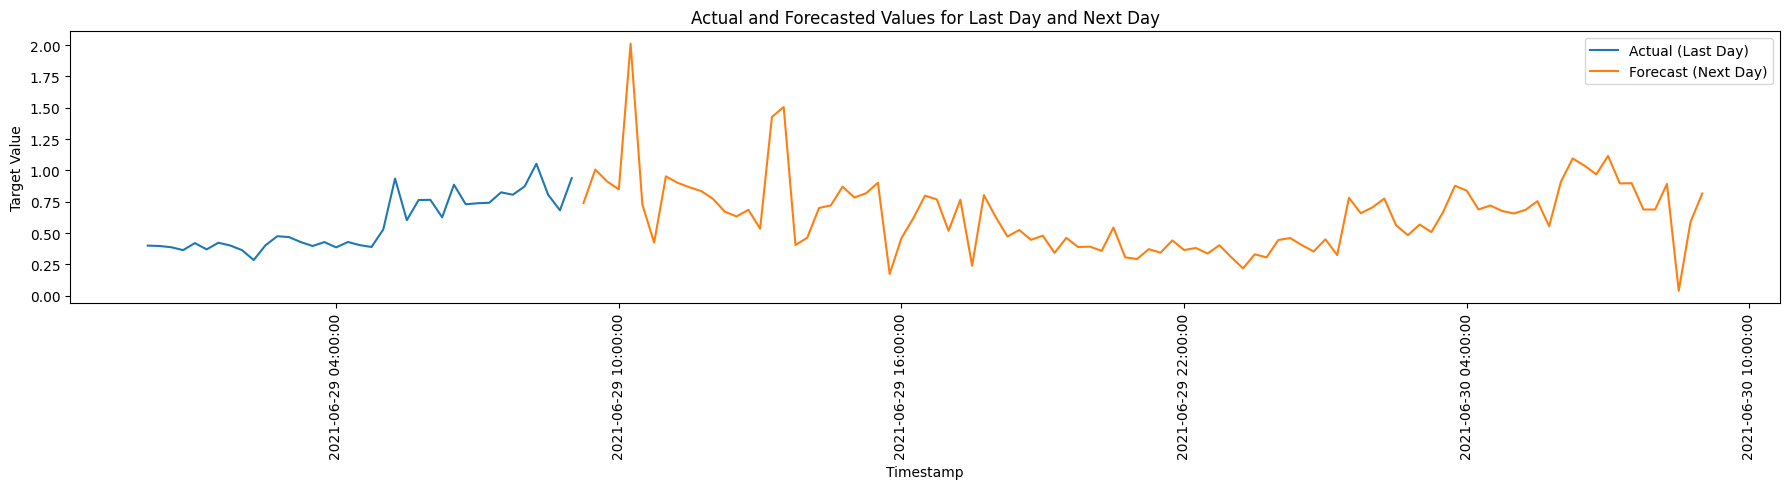

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_forecasts(test_dataset, forecasts):
    # Extract the timestamp and target values for the last day from the test dataset
    timestamps_last_day = pd.date_range(start=test_dataset[0]['start'].to_timestamp(), periods=len(test_dataset[0]['target']), freq='15min')
    target_values_last_day = test_dataset[0]['target']

    # Filter timestamps and target values for the last day (June 29)
    last_day_mask = timestamps_last_day.date == pd.Timestamp('2021-06-29').date()
    timestamps_last_day = timestamps_last_day[last_day_mask]
    target_values_last_day = target_values_last_day[last_day_mask]

    # Plot only the last day's actual target values
    plt.plot(timestamps_last_day, target_values_last_day, label='Actual (Last Day)')

    # Extract the forecasted values for the day after the last day
    forecast_values_next_day = forecasts[0][0]  # Assuming you have only one forecast

    # Generate timestamps for the day after the last day (June 30)
    start_timestamp_next_day = timestamps_last_day[-1] + pd.Timedelta(minutes=15)  # Start from the next time interval after the last timestamp of the last day
    forecast_timestamps_next_day = pd.date_range(start=start_timestamp_next_day, periods=len(forecast_values_next_day), freq='15min')

    # Plot the forecasted values for the day after the last day
    plt.plot(forecast_timestamps_next_day, forecast_values_next_day, label='Forecast (Next Day)')

    # Format the x-axis ticks for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Set interval as needed

    plt.xlabel('Timestamp')
    plt.ylabel('Target Value')
    plt.title('Actual and Forecasted Values for Last Day and Next Day')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Plot the forecasts
plot_forecasts(test_dataset, forecasts)


- 6/29 time ends with 9 because afterwards there's no data.
- the model is predicting for 24 hrs after the actual data ends aka starting from 9:15pm
- see code below for more info

array([0.4  , 0.397, 0.387, 0.364, 0.42 , 0.37 , 0.423, 0.401, 0.364,
       0.285, 0.403, 0.475, 0.468, 0.428, 0.397, 0.428, 0.386, 0.429,
       0.404, 0.389, 0.529, 0.935, 0.603, 0.764, 0.765, 0.626, 0.886,
       0.73 , 0.738, 0.742, 0.825, 0.806, 0.872, 1.053, 0.806, 0.682,
       0.938], dtype=float32)

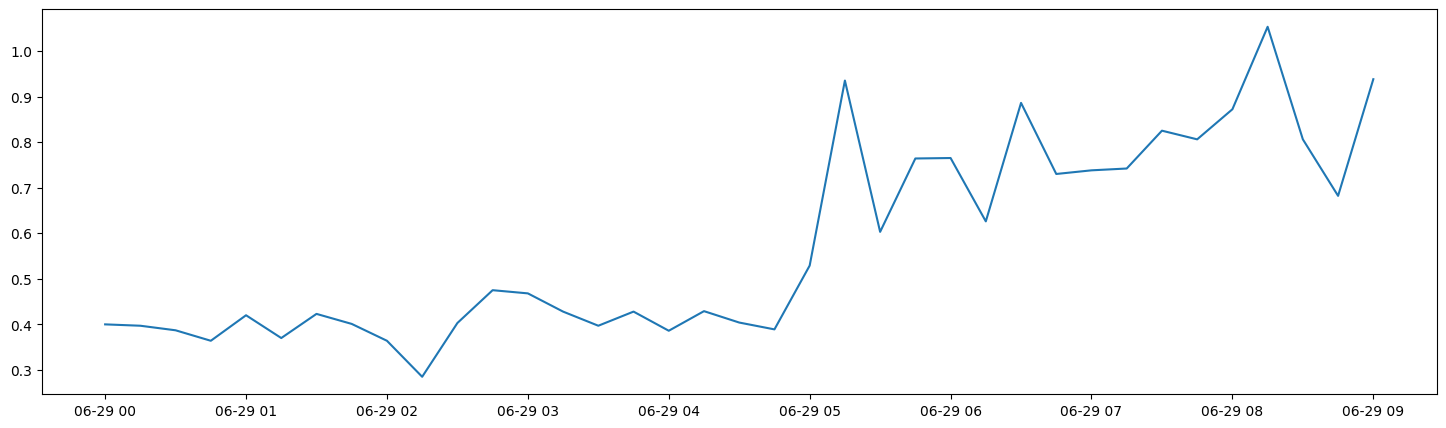

In [106]:
# just to cross-check the actual value with dataset

timestamps_last_day = pd.date_range(start=test_dataset[0]['start'].to_timestamp(), periods=len(test_dataset[0]['target']), freq='15min')
target_values_last_day = test_dataset[0]['target']

# Filter timestamps and target values for the last day (June 29)
last_day_mask = timestamps_last_day.date == pd.Timestamp('2021-06-29').date()
timestamps_last_day = timestamps_last_day[last_day_mask]
target_values_last_day = target_values_last_day[last_day_mask]

# Plot only the last day's actual target values
plt.plot(timestamps_last_day, target_values_last_day, label='Actual (Last Day)')

target_values_last_day # checked with dataset. the values are correct.

forecast timestamps: 
 DatetimeIndex(['2021-06-29 09:15:00', '2021-06-29 09:30:00',
               '2021-06-29 09:45:00', '2021-06-29 10:00:00',
               '2021-06-29 10:15:00', '2021-06-29 10:30:00',
               '2021-06-29 10:45:00', '2021-06-29 11:00:00',
               '2021-06-29 11:15:00', '2021-06-29 11:30:00',
               '2021-06-29 11:45:00', '2021-06-29 12:00:00',
               '2021-06-29 12:15:00', '2021-06-29 12:30:00',
               '2021-06-29 12:45:00', '2021-06-29 13:00:00',
               '2021-06-29 13:15:00', '2021-06-29 13:30:00',
               '2021-06-29 13:45:00', '2021-06-29 14:00:00',
               '2021-06-29 14:15:00', '2021-06-29 14:30:00',
               '2021-06-29 14:45:00', '2021-06-29 15:00:00',
               '2021-06-29 15:15:00', '2021-06-29 15:30:00',
               '2021-06-29 15:45:00', '2021-06-29 16:00:00',
               '2021-06-29 16:15:00', '2021-06-29 16:30:00',
               '2021-06-29 16:45:00', '2021-06-29 17:00:00',
 

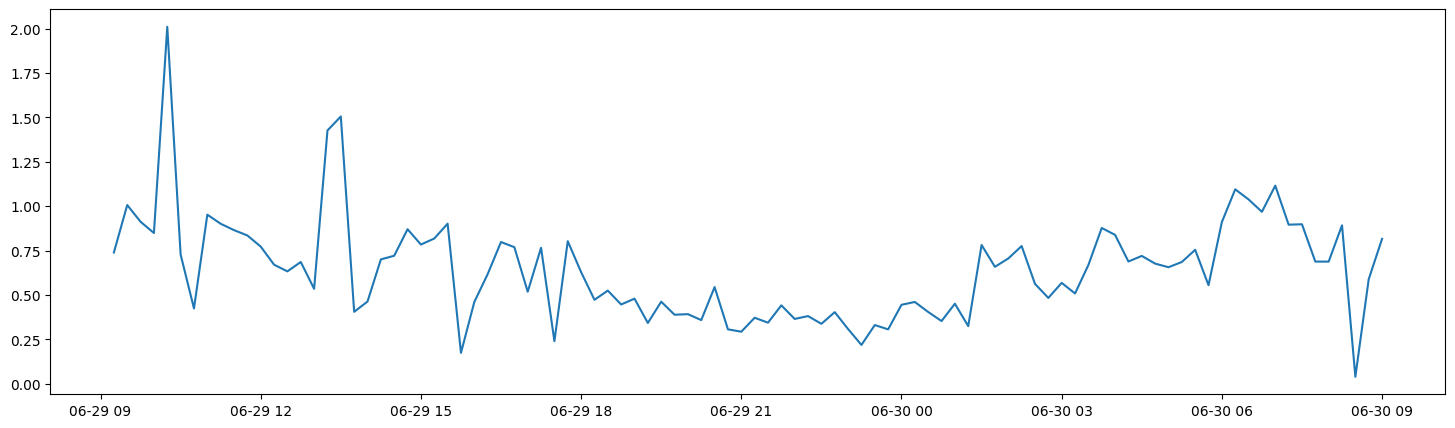

In [119]:
# start and end time for this particular forecast task

# Extract the forecasted values for the day after the last day
forecast_values_next_day = forecasts[0][0]  # Assuming you have only one forecast

# Generate timestamps for the day after the last day (June 30)
start_timestamp_next_day = timestamps_last_day[-1] + pd.Timedelta(minutes=15)  # Start from the next time interval after the last timestamp of the last day
forecast_timestamps_next_day = pd.date_range(start=start_timestamp_next_day, periods=len(forecast_values_next_day), freq='15min')

print("forecast timestamps: \n", forecast_timestamps_next_day)
print("forecast value: \n", forecast_values_next_day)

# Plot the forecasted values for the day after the last day
plt.plot(forecast_timestamps_next_day, forecast_values_next_day, label='Forecast (Next Day)')
